
# Bootstrapping TDS calculations made from geophysical well logs in the Hill Country Trinity Aquifer

### Alysa Suydam, TX PG 15118, Graduate Student
#### Earth and Energy Resources, The Jackson School of Geosciences
##### [Texas Water Development Board BRACS program](https://www.twdb.texas.gov/innovativewater/bracs/index.asp) | aksuydam@utexas.edu | [LinkedIn](https://www.linkedin.com/in/alysa-suydam-18aa29a3/)

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary
Mapping inland brackish groundwater (1,000 mg/L to 10,000 mg/L total dissolved solids) is an important first step in identifying the resource for potential desalination. Due to the lack of directly measured water quality samples from these salinity ranges, we rely on interpreted geophysical well logs for mapping. I used bootstrapping to estimate the uncertainty in the TDS calculation methodology used in the draft groundwater mapping study for the Hill Country portion of the Trinity Aquifer in Texas. From this excercise, I learned:
* there is significant uncertainty in the calculated TDS;
* some mapped formations have more uncertainty than other formations;
* and the results of the Hill Country Trinity Aquifer study should be used to target areas for further investigation rather than as a guide to placing groundwater production wells.

#### Background
The TWDB is interested in mapping inland brackish groundwater as a potential future water supply in the state. Mapping studies result in an estimate of where the brackish groundwater is located, the salinity of the brackish groundwater, and volume estimates. This information can provide essential baseline information for future studies.

Mapping in the [Hill Country portion of the Trinity Aquifer](https://www.twdb.texas.gov/innovativewater/bracs/studies/HillCountry_Trinity/index.asp) is an extension of the [Northern Trinity](https://www.twdb.texas.gov/innovativewater/bracs/studies/Northern_Trinity/index.asp) mapping project. We mapped six water-bearing formations:
* the Upper Glen Rose Limestone,
* the Lower Glen Rose Limestone,
* the Hensell Sand,
* the Cow Creek Limestone,
* the Sligo Limestone,
* and the Hosston Sand.

Since we often lack measured water quality data for brackish salinity ranges, we indirectly estimate groundwater salinity using resistivity logs and various calculation methods. We often use old logs (1950s to present) because the surface casing in old logs is often shallower than in modern logs, and resistivity tools are logged over the shallow subsurface. In addition to using logs over seven decades with tools of various designs and calibrations, we only use publicly available data. This means most of our data is limited to the information provided on the log and log header. We do not know how accurate the tools are, how accurate the mud and mud filtrate resistivity measurements are, etc.

In addition to the challenges the log data provides, we present salinity information mapped as total dissolved solids (mg/L) rather than water conductivity to make our maps readable by the general public. We build empirical relationships between TDS and specific conductivity (SC) of measured water quality samples, but our measured water quality data is often limited beyond 1,000 mg/L TDS and non-existent beyond 4,000 mg/L TDS. One of the mapping goals of a study is to map groundwater salinity through 35,000 mg/L TDS. For the Hill Country Trinity Aquifer study, for some of the mapped formations we used data from different but similar formations to extend our TDS and SC relationships. For others, we used best professional judgement to estimate the chemical composition at increased salinity ranges, and therefore also estimated SC.

Given the well log data and sparse measured water quality, there should be significant uncertainty in the estimated TDS values. I performed a bootstrapping routine on the data to try and get a handle on how much uncertainty there is in the TDS calculations of the dataset.

### Worflow overview
1. Load data
2. Create various dataframes, view summary statistics, and view relationships between the calculation input parameters
3. Bootstrap the TDS values and visualize results for:
    * the entire dataset,
    * the dataset with calculated TDS less than or equal to 35,000 mg/L,
    * and each mapped formation.
4. Bootstrap the TDS calculations and visualize results for:
    * the entire dataset,
    * the dataset with calculated TDS less than or equal to 35,000 mg/L,
    * and each mapped formation.
5. Compare the original dataset to a few individual bootstrap sample events.

## Import packages

In [1]:
import numpy as np                     #to work with nd arrays
import pandas as pd                    #to work with dataframes and tabular data
import os                              #to set the working directory
import seaborn as sns                  #for plotting
import random                          #to randomly choose data for bootstrapping
import matplotlib.pyplot as plt        #for plotting
from scipy import stats                #for summary statistics
import array                           #to work with arrays

## Functions
The bootstrap functions used are modified from a workflow from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_bootstrap.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_bootstrap.ipynb).

The Hill Country Trinity Alger-Harrison calculation function was modified from a vba module I wrote to use within the BRACS program in a MS Access database.

In [2]:
def HCT_AlgerHarrison(Dt,Ts,TBH,Df,Rm,T_Rm,Rmf,T_Rmf,Rxo,Ro,StratName):
    ###Calculation method used to estimate Total Dissolved Solids (TDS) from log header parameters and resistivity 
    ###readings
    
    #get corrected bottom hole temperature (Blackwell et al., 2010) and calculate the geothermal gradient
    if Dt<3000:
        TBH_cor=TBH
    elif 3000<=Dt<=12900:
        Dtm=Dt/3.281
        TBHC=(TBH-32)*(5/9)
        TBHC_cf=-16.51213476+0.01826842109*Dtm-0.000002344936959*Dtm**2
        TBH_cor=1.8*(TBHC+TBHC_cf)+32
    elif Dt>12900:
        TBH_cf=((Dt-12900)/500)*0.05
        TBH_cor=TBH+34.3+TBH_cf
    #calculate geothermal gradient, Gg
    Gg=(TBH_cor-Ts)/Dt
    
    #calculate the temperature of the formation at the depth of interest
    Tf=(Gg*Df)+Ts
    
    #calculate Rmf at depth of interest (Df)
    if Rmf==0 or T_Rmf==0:
        Rm75=Rm*(T_Rm/75)
        Rmf75=0.9157*Rm75-0.1446
        Rmf=Rmf75
        T_Rmf=75
    Rmf_Tf=Rmf*(T_Rmf/Tf)
    
    #calculate Rxo/Ro ratio used in the Alger-Harrison Method
    Rxo_Ro=Rxo/Ro
    
    #calculate the water resistivity at the formation temperature (Alger and Harrison, 1989)
    Rw=Rmf_Tf/Rxo_Ro
    
    #convert the water resistivity to a resistivity at 75 degrees Fahrenheit
    Rw75=Rw*(Tf/75)
    
    #convert the water resistivity to a conductivity
    Cw75=10000/Rw75
     
    #convert conductivity to TDS based on specific conductivity and TDS relationships
    if (StratName=='Upper Glen Rose Formation' or StratName=='Lower Glen Rose Formation') and Cw75<=4000:
        TDS=int((9*10**-5)*(Cw75**2)+(0.6622*Cw75)+76.044)
    elif (StratName=='Hensell Sand' or StratName=='Cow Creek Limestone') and Cw75 <=4000:
        TDS=int(0.0001*(Cw75**2)+(0.4215*Cw75)+222.14)
    elif (StratName=='Sligo Limestone' or StratName=='Hosston Sand') and Cw75<=4900:
        TDS=int((0.7029*Cw75)+84.748)
    elif (StratName=='Upper Glen Rose Formation' or StratName=='Lower Glen Rose Formation' or StratName=='Hensell Sand' 
          or StratName=='Cow Creek Limestone') and 4000<Cw75<=15000:
        TDS=int((0.5801*Cw75)+1826.5)
    elif (StratName=='Sligo Limestone' or StratName=='Hosston Sand') and 4900<Cw75<=10000:
        TDS=int((0.377*Cw75)+1699.3)
    elif (StratName=='Upper Glen Rose Formation' or StratName=='Lower Glen Rose Formation' or StratName=='Hensell Sand' 
          or StratName=='Cow Creek Limestone') and Cw75>15000:
        TDS=int((0.6644*Cw75)+442.87)
    elif (StratName=='Sligo Limestone' or StratName=='Hosston Sand') and Cw75>10000:
        TDS=int((0.6388*Cw75)-951.91)       
    return(TDS)

def RandomPoint_Bootstrap(L,df,title):
    ###bootstrap the TDS calculations without making everything random. This function will return a plot of the 
    ###bootstrap realizations and the average mean, standard deviation, P10, P50, and P90.

    #arrays to hold summary statistics for calculated TDS
    mean=np.zeros(L)
    stdev=np.zeros(L)
    P10=np.zeros(L)
    P50=np.zeros(L)
    P90=np.zeros(L)
    
    #begin bootstrapping
    for l in range(0,L):
        #array of randomly selected TDS samples
        TDS_calcs=random.choices(df['TDS'].values,k=len(df))
        #assign summary data to array
        mean[l]=np.average(TDS_calcs)
        stdev[l]=np.std(TDS_calcs)
        P10[l]=np.percentile(mean,10)
        P50[l]=np.percentile(mean,50)
        P90[l]=np.percentile(mean,90)
        #plot TDS distribution
        sns.kdeplot(TDS_calcs,color='black',linewidth=0.001)
    plt.title(title)
    plt.xlabel('Estimated total dissolved solids (TDS, mg/L)')
    plt.ylabel('Density')
    
    #save summary data from all the bootstrap sample events to a variable that gets returned from the function
    mean_v=round(np.average(mean),0)
    stdev_v=round(np.average(stdev),0)
    P10_v=round(np.average(P10),0)
    P50_v=round(np.average(P50),0)
    P90_v=round(np.average(P90),0)

    return(plt,mean_v,stdev_v,P10_v,P50_v,P90_v)

def RandomValue_Bootstrap(L,df,title):
    ###This function bootstraps the TDS calculations. It randomly selects input parameters, calculates TDS, and then 
    ###plots the results. It will also return the average mean, standard deviation, P10, P50, and P90 values.
    
    #arrays to store summary statistics for calculated TDS
    mean=np.zeros(L)
    stdev=np.zeros(L)
    P10=np.zeros(L)
    P50=np.zeros(L)
    P90=np.zeros(L)
    
    #begin bootstrapping
    for l in range(0,L):
        #randomly sample with replacement the calculation input data and assign it to an array
        Dt_array=random.choices(df['LR_BD'].values,k=len(df))
        Ts_array=random.choices(df['TS'].values,k=len(df))
        TBH_array=random.choices(df['LR_TBH'].values,k=len(df))
        Df_array=random.choices(df['DF'].values,k=len(df))
        Rm_array=random.choices(df['LR_RM'].values,k=len(df))
        T_Rm_array=random.choices(df['LR_RM_TEMP'].values,k=len(df))
        Rmf_array=random.choices(df['LR_RMF'].values,k=len(df))
        T_Rmf_array=random.choices(df['LR_RMF_TEMP'].values,k=len(df))
        Rxo_array=random.choices(df['RXO'].values,k=len(df))
        Ro_array=random.choices(df['RO'].values,k=len(df))
        StratName_array=random.choices(df['STRATIGRAPHIC_NAME'].values,k=len(df))
        
        #Array to store calculated parameters
        TDS_calcs=np.zeros(int(len(df)))
        
        #pass the calculation parameters to our calculating function and assign the result to the TDS array
        for n in range(0,len(df)):
            TDStemp=HCT_AlgerHarrison(Dt_array[n],Ts_array[n],TBH_array[n],Df_array[n],Rm_array[n],T_Rm_array[n],
                                           Rmf_array[n],T_Rmf_array[n],Rxo_array[n],Ro_array[n],StratName_array[n])
            #when we randomly select all input parameters, we can get some Df and LR_TBH combinations that are 
            #unreasonable, like Df=14000 and LR_TBH=70. These types of combinations can result in a negative TDS. 
            #We will assign TDS values less than or equal to zero as NaN
            if TDStemp>0:
                TDS_calcs[n]=TDStemp
            elif TDStemp<=0:
                TDS_calcs[n]='NaN'
        
        #store summary statistics in our summary arrays
        mean[l]=np.average(TDS_calcs)
        stdev[l]=np.std(TDS_calcs)
        P10[l]=np.percentile(TDS_calcs,10)
        P50[l]=np.percentile(TDS_calcs,50)
        P90[l]=np.percentile(TDS_calcs,90)
        
        #plot the results
        sns.kdeplot(TDS_calcs,color='black',log_scale=True,linewidth=0.001)
    #label the plot
    plt.title(title)
    plt.xlabel('Estimated total dissolved solids (TDS, mg/L)')
    plt.ylabel('Density')
    
    #save summary data from all the bootstrap sample events to a variable that gets returned from the function
    mean_v=round(np.nanmean(mean),0)
    stdev_v=round(np.nanmean(stdev),0)
    P10_v=round(np.nanmean(P10),0)
    P50_v=round(np.nanmean(P50),0)
    P90_v=round(np.nanmean(P90),0)

    return(plt,mean_v,stdev_v,P10_v,P50_v,P90_v)
    
def RandomValueOnce_Bootstrap(df,plot_type):
    ###This function is essentially the same as RandomValue_Bootstrap(), but it returns 1 bootstrap sample event plot
    ###and no summary statistics.
    
    #plot_type can be 'RXO/RO' or 'LR_TBH'
    
    L=1
    
    #begin bootstrapping
    for l in range(0,L):
        #randomly sample with replacement the calculation input data and assign it to an array
        Dt_array=random.choices(df['LR_BD'].values,k=len(df))
        Ts_array=random.choices(df['TS'].values,k=len(df))
        TBH_array=random.choices(df['LR_TBH'].values,k=len(df))
        Df_array=random.choices(df['DF'].values,k=len(df))
        Rm_array=random.choices(df['LR_RM'].values,k=len(df))
        T_Rm_array=random.choices(df['LR_RM_TEMP'].values,k=len(df))
        Rmf_array=random.choices(df['LR_RMF'].values,k=len(df))
        T_Rmf_array=random.choices(df['LR_RMF_TEMP'].values,k=len(df))
        Rxo_array=random.choices(df['RXO'].values,k=len(df))
        Ro_array=random.choices(df['RO'].values,k=len(df))
        StratName_array=random.choices(df['STRATIGRAPHIC_NAME'].values,k=len(df))
        
        #Array to store calculated parameters
        TDS_calcs=np.zeros(int(len(df)))
        
        #pass the calculation parameters to our calculating function and assign the result to the TDS array
        for n in range(0,len(df)):
            TDStemp=HCT_AlgerHarrison(Dt_array[n],Ts_array[n],TBH_array[n],Df_array[n],Rm_array[n],T_Rm_array[n],
                                           Rmf_array[n],T_Rmf_array[n],Rxo_array[n],Ro_array[n],StratName_array[n])
            #when we randomly select all input parameters, we can get some Df and LR_TBH combinations that are 
            #unreasonable, like Df=14000 and LR_TBH=70. These types of combinations can result in a negative TDS. 
            #We will assign TDS values less than or equal to zero as NaN
            if TDStemp>0:
                TDS_calcs[n]=TDStemp
            elif TDStemp<=0:
                TDS_calcs[n]='NaN'
        
        #turn some of the arrays into a dataframe for easy scatter plots
        data={'DF':Df_array,'RMF':Rmf_array,'RXO':Rxo_array,'RO':Ro_array,'TDS':TDS_calcs,'LR_TBH':TBH_array}
        df_random=pd.DataFrame(data,columns=['DF','RMF','RXO','RO','TDS','LR_TBH'])
        
        #We will plot TDS v RXO/RO or LR_TBH v DF to compare the bootstrapped calculations to the original dataset for 
        #one bootstrap sampling event.
        if plot_type == 'RXO/RO':
            plt.scatter(y=df_random['TDS'],x=(df_random['RXO']/df_random['RO']),color='orange')
        elif plot_type=='LR_TBH':
            plt.scatter(y=df_random['LR_TBH'],x=df_random['DF'],color='orange')
        else:
            print('Please select one of the two plot options: ''RXO/RO'' or ''LR_TBH''.')
    
    #label the plot
    plt.title('One bootstrap sample event')
    if plot_type=='RXO/RO':
        plt.ylabel('TDS, mg/L')
        plt.xlabel('Rxo/Ro')
    elif plot_type=='LR_TBH':
        plt.ylabel('Log run bottom hole temperature,\ndegrees Fahrenheit')
        plt.xlabel('Depth of calculation, feet')
    
    return(plt)

## Load the data
We will use a dataset compiled to map groundwater salinity in the Trinity Aquifer in the Hill Country of Texas. Mapped water-bearing formations include:
* the Upper Glen Rose Limestone,
* the Lower Glen Rose Limestone,
* the Hensell Sand,
* the Cow Creek Limestone,
* the Sligo Limestone,
* and the Hosston Sand.

Data was harvested from geophysical well log headers, and logs were interpreted for optimal depths to calculate groundwater salinity. Raw data is available in the BRACS [database](https://www.twdb.texas.gov/innovativewater/bracs/database.asp). The processed dataset will be available as a shapefile upon the study completion from the study [webpage](https://www.twdb.texas.gov/innovativewater/bracs/studies/HillCountry_Trinity/index.asp).

We use a modification of the Alger-Harrison resistivity ratio method (Alger and Harrison, 1989) to estimate groundwater salinity. The calculation requires the following input parameters:
* Dt, the total depth of the log run in feet (reported on the log header)
* Ts, the 30-year average surface temperature in degrees Fahrenheit (Larkin and Bomar, 1983)
* TBH, the bottom hole temperature of the log run in degrees Fahrenheit (reported on the log header)
* Df, the depth the calculation was performed at in feet below Kelly Bushing (or other measuring point) (read from the log)
* Rm, the resistivity of the log run mud filtrate in ohm-meter (reported on the log header)
* T_Tm, the temperature of the log run mud in degrees Fahrenheit (reported on the log header)
* Rmf, the resistivity of the log run mud filtrate in ohm-meter (reported on the log header)
* T_Rmf, the temperature of the log run mud filtrate in degrees Fahrenheit (reported on the log header)
* Rxo, the shallow resistivity in ohm-meter (read from the log at Df)
* Ro, the deep resistivity in ohm-meter (read from the log at Df)
* StratName, the name of mapped unit the calculation is conducted in

Additional useful fields include the BRACS ID (WELL_ID) and the geophysical well log ID (GL_NUMBER). These can be used to access other data in the BRACS database, including the well logs used for interpretation.

Navigate to the directory with the dataset:

In [3]:
os.chdir(r"C:\Users\aksuy\Documents\grad_school\GEO391_SubsurfaceMachineLearning\project")

### Assign dataset to a dataframe
We will limit the dataframe to the parameters we are working with and we'll also look at the first 5 records.

In [4]:
df_total=pd.read_csv('PGE383_Project_Alysa_Suydam_data.csv')
df_total=df_total.iloc[:,np.r_[0,1,2,3,4,5,6,7,8,9,14,19,20,21,22,23,24]]
df_total.head()

,WELL_ID,GL_NUMBER,DF,STRATIGRAPHIC_NAME,TDS,CW,RXO,RO,RMF_TF,TF,TS,LR_BD,LR_TBH,LR_RM,LR_RM_TEMP,LR_RMF,LR_RMF_TEMP
0,6433,84346,598,Hosston Sand,1708,2309.47,345.0,1250.0,1.30,70,65,3353,95,1.44,77.0,0.0,0
1,6457,81012,570,Upper Glen Rose Formation,1152,1369.86,13.0,15.0,6.61,72,65,1133,79,7.41,68.0,7.0,68
2,6457,81012,619,Upper Glen Rose Formation,1012,1213.59,20.0,26.0,6.52,73,65,1133,79,7.41,68.0,7.0,68
3,6457,81012,833,Lower Glen Rose Formation,782,945.18,36.0,60.0,6.35,75,65,1133,79,7.41,68.0,7.0,68
4,6457,81012,852,Lower Glen Rose Formation,757,914.91,40.0,69.0,6.26,76,65,1133,79,7.41,68.0,7.0,68


### Get summary statistics for the entire dataset
Some things to note:
* calculated TDS ranges from 187 to 133,323 mg/L
* calculation depths range from fairly shallow (101 feet below Kelly Bushing (KB)) to relatively deep for groundwater (14,282 feet below KB))
* not all logs report a mud filtrate resistivity (Rmf), which is essential to the Alger-Harrison resistivity ratio method
    

In [5]:
df_total.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,1487.0,45133.075992,28144.031263,6433.00,19882.00,36559.00,84832.000,87214.00
GL_NUMBER,1487.0,60091.720242,39374.391594,9787.00,21201.00,57509.00,82487.000,118996.00
DF,1487.0,4329.256893,3021.499240,101.00,2000.00,3723.00,6115.000,14282.00
TDS,1487.0,14202.593141,16573.517976,187.00,4200.00,8306.00,18163.500,133323.00
CW,1487.0,20966.479260,25186.194720,164.53,4504.50,11764.71,27777.780,200000.00
RXO,1487.0,52.555481,81.292132,0.60,16.00,30.00,57.500,1050.00
RO,1487.0,43.983719,84.181568,0.40,6.00,20.00,48.000,1250.00
RMF_TF,1487.0,1.982105,2.750218,0.04,0.40,1.01,1.915,22.17
TF,1487.0,137.484869,53.824458,66.00,98.00,124.00,166.000,332.00
TS,1487.0,67.944183,1.471206,65.00,67.00,68.00,69.000,71.00


### Visualize the relationships between the parameters used in the calculation
As noted in the previous step, not all logs report Rmf values, so we utilized the colinear relationship between Rm and Rmf to estimate Rmf when unavailable. To get this relationship, we performed a linear regression of 259 well logs with both the Rm and Rmf values transformed to 75 degrees Fahrenheit. The resulting linear regression equation is used in HCT_AlgerHarrison().

Another mostly colinear relationship is Df and LR_TBH. We estimate the temperature of the formation (Tf) at the depth of calculation (Df) using a simple gradient based equation and corrections outlined in Blackwell et al. (2010), which are summarized in HCT_AlgerHarrison().

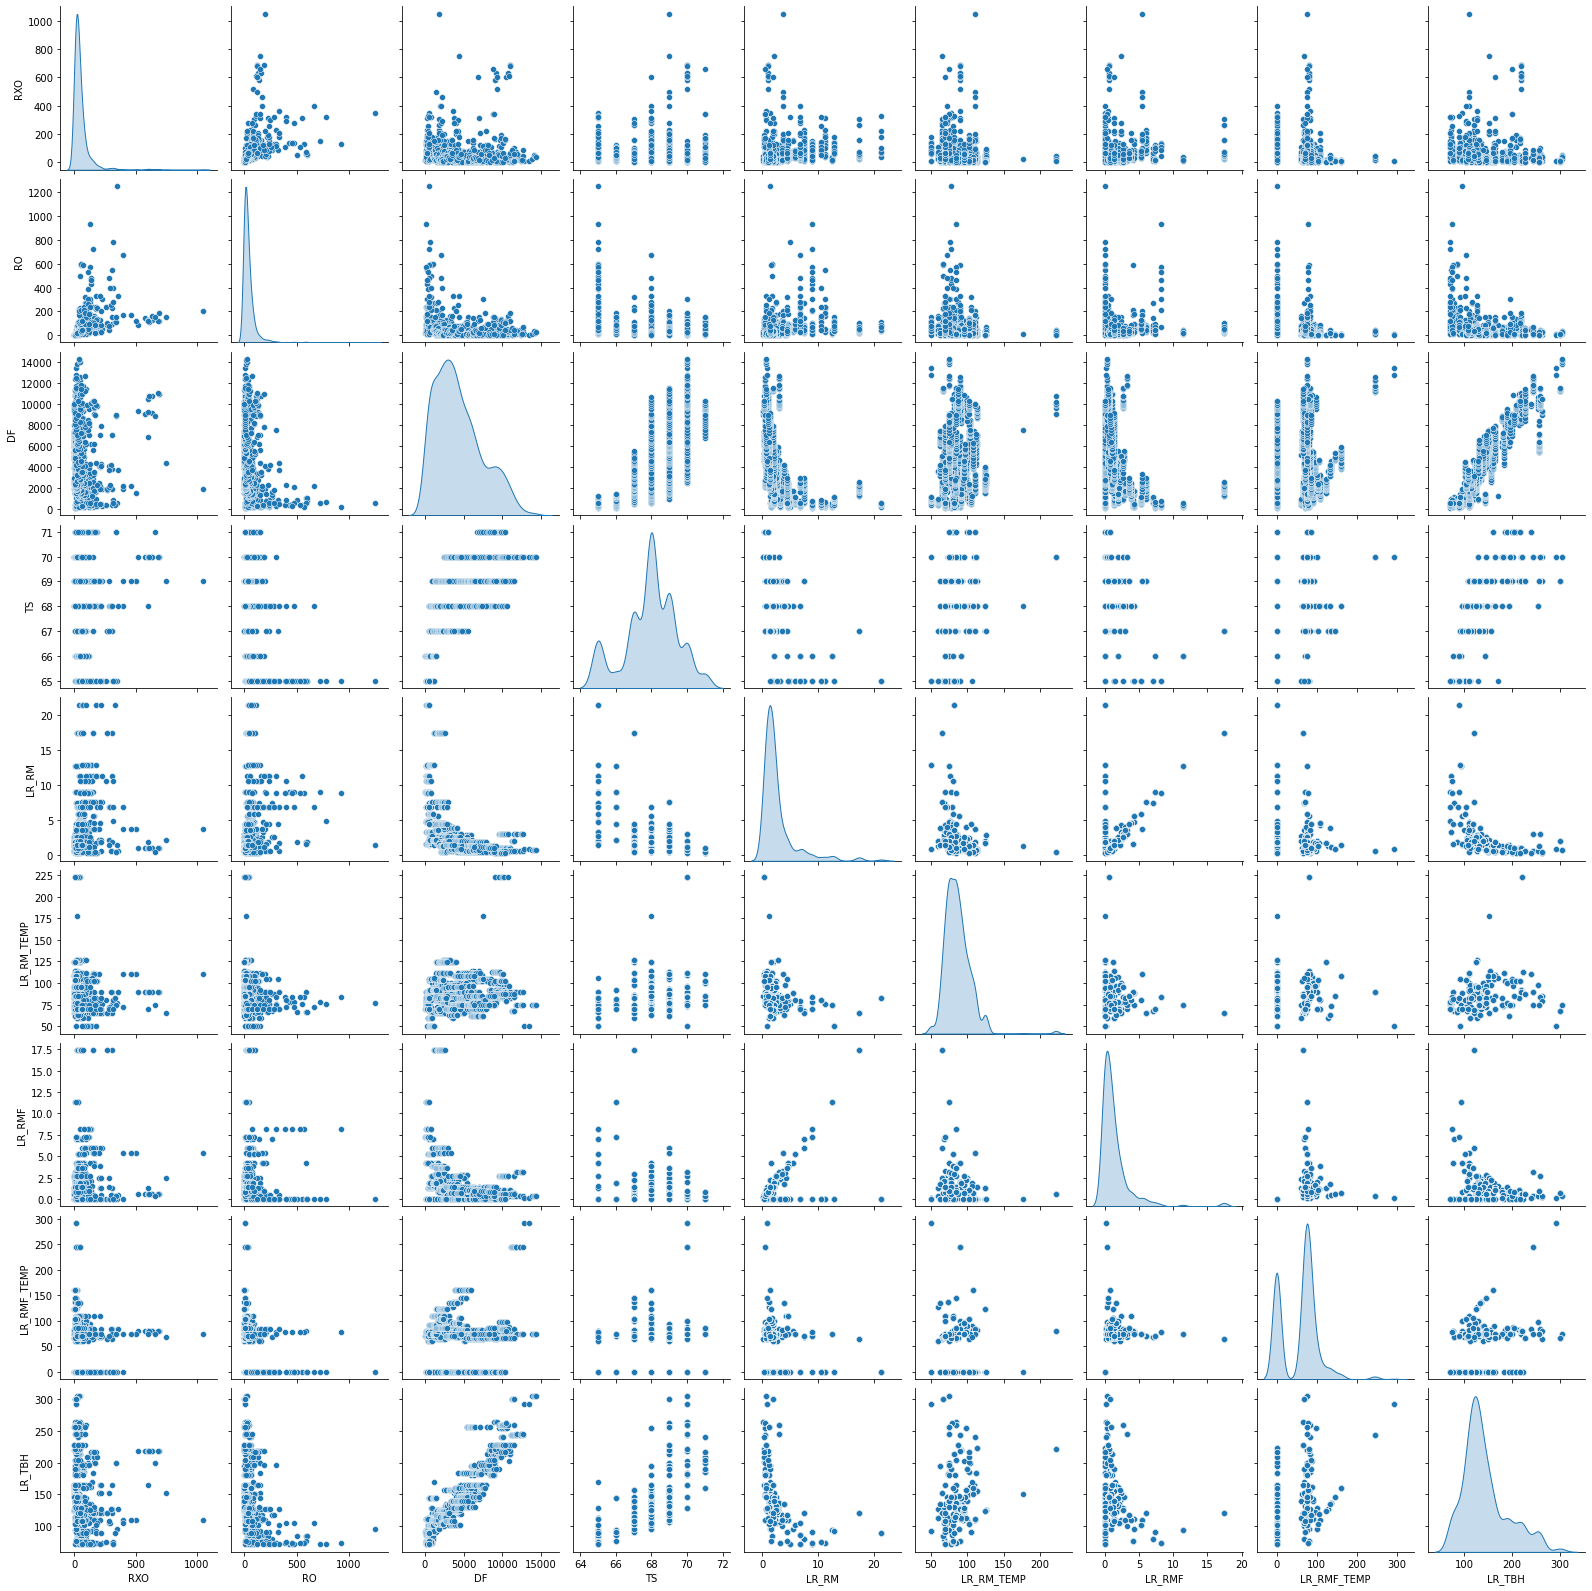

In [6]:
sns.pairplot(df_total,vars=['RXO','RO','DF','TS','LR_RM','LR_RM_TEMP','LR_RMF','LR_RMF_TEMP','LR_TBH'],markers='o',kind='scatter',diag_kind='kde')

### Visualize the TDS distribution and calculate the mean and standard deviation
TDS is likely strongly skewed right due to bias in our mapping objective. We are most interested in delineating areas with groundwater salinity less than 35,000 mg/L. Additionally, most of the depths we performed calculations at are relatively shallow (Df v Df from the matrix scatter plot above peaks at less than 5000 feet).

TDS summary statistics
Mean TDS: 14203.0
Standard deviation of TDS: 16567.94


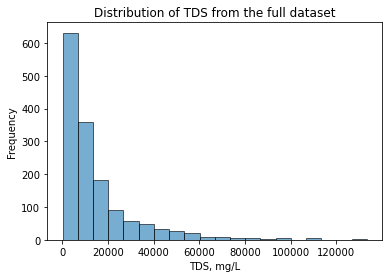

In [7]:
mean_TDS=round(np.average(df_total['TDS']),0)
std_TDS=round(np.std(df_total['TDS']),2)

print('TDS summary statistics')
print('Mean TDS: ' +str(mean_TDS))
print('Standard deviation of TDS: '+str(std_TDS))
plt.hist(df_total['TDS'],bins=20,alpha=0.6,edgecolor='black')
plt.title('Distribution of TDS from the full dataset')
plt.xlabel('TDS, mg/L')
plt.ylabel('Frequency');

### Create a dataframe that holds TDS values that are less than or equal 35,000 mg/L TDS
Since the data is stongly skewed right, it might be interesting to make another dataframe (df_select) that focuses on the mapping objective, which is TDS less than or equal to 35,000 mg/L.

In [8]:
df_select=df_total[df_total['TDS']<=35000]
df_select.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,1329.0,44728.455982,27949.634364,6433.00,19346.00,36559.00,83097.00,87214.00
GL_NUMBER,1329.0,59342.194131,39123.827960,9787.00,21183.00,57506.00,82288.00,118996.00
DF,1329.0,3977.021821,2897.742071,101.00,1761.00,3434.00,5436.00,14282.00
TDS,1329.0,9532.563582,7920.426519,187.00,3540.00,7248.00,13566.00,34537.00
CW,1329.0,13919.210640,12392.003587,164.53,3968.25,9803.92,20833.33,55555.55
RXO,1329.0,50.866516,70.333721,0.60,16.00,32.00,60.00,1050.00
RO,1329.0,47.004801,87.694145,0.40,7.50,24.00,50.00,1250.00
RMF_TF,1329.0,2.179248,2.844619,0.05,0.47,1.15,2.29,22.17
TF,1329.0,131.381490,51.507088,66.00,95.00,119.00,154.00,332.00
TS,1329.0,67.832957,1.474409,65.00,67.00,68.00,69.00,71.00


Let's look at the new TDS distribution and summary statistics. Immediately we see that the there is a tighter distribution of TDS, as the standard deviation is less than the mean. The TDS distribution is still skewed right.

TDS summary statistics
Mean TDS: 9533.0
Standard deviation of TDS: 7917.45


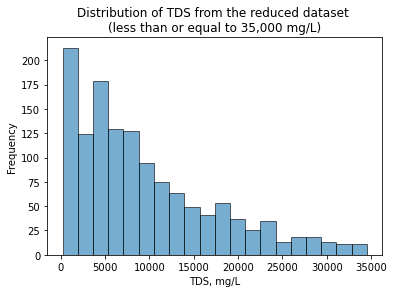

In [9]:
mean_TDS2=round(np.average(df_select['TDS']),0)
std_TDS2=round(np.std(df_select['TDS']),2)

print('TDS summary statistics')
print('Mean TDS: ' +str(mean_TDS2))
print('Standard deviation of TDS: '+str(std_TDS2))
plt.hist(df_select['TDS'],bins=20,alpha=0.6,edgecolor='black')
plt.title('Distribution of TDS from the reduced dataset \n(less than or equal to 35,000 mg/L)')
plt.xlabel('TDS, mg/L')
plt.ylabel('Frequency');

### Split the mapped formations into seperate dataframes
Aside from investigating excluding very saline samples, we'll bootstrap the individual mapped formations to see if one has more uncertainty in the calculated TDS than another.

The Upper Glen Rose Limestone:

In [10]:
UGR=df_total[df_total['STRATIGRAPHIC_NAME']=='Upper Glen Rose Formation']
UGR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,447.0,45422.494407,29273.501356,6457.00,19245.000,34999.00,85109.00,86809.00
GL_NUMBER,447.0,59962.550336,41398.857165,9787.00,19701.000,57556.00,117057.00,118968.00
DF,447.0,4520.881432,2882.655558,124.00,2249.000,3796.00,6254.50,11505.00
TDS,447.0,15512.011186,14992.841890,187.00,6108.000,10114.00,19426.00,133323.00
CW,447.0,22247.986286,22844.910431,164.53,7380.175,14285.71,28571.43,200000.00
RXO,447.0,38.771365,61.856449,1.70,16.800,26.50,40.75,630.00
RO,447.0,25.067785,49.441036,0.80,7.000,15.00,31.00,930.00
RMF_TF,447.0,1.399485,1.987034,0.05,0.365,0.84,1.64,22.17
TF,447.0,141.548098,53.539196,66.00,99.000,124.00,179.50,332.00
TS,447.0,68.371365,1.254904,65.00,68.000,68.00,69.00,71.00


The Lower Glen Rose Limestone:

In [11]:
LGR=df_total[df_total['STRATIGRAPHIC_NAME']=='Lower Glen Rose Formation']
LGR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,400.0,46729.135000,28786.379373,6457.00,19882.0000,37777.00,85109.00,87214.00
GL_NUMBER,400.0,62099.125000,40103.433815,9787.00,22525.0000,57563.00,117052.25,118996.00
DF,400.0,4380.312500,2996.225862,101.00,2045.7500,3967.50,6330.25,12278.00
TDS,400.0,18014.882500,20387.699776,262.00,4924.7500,9773.00,23353.00,111176.00
CW,400.0,26105.040350,30885.485129,270.42,5340.4800,13698.63,34482.76,166666.70
RXO,400.0,57.874500,101.473010,1.00,14.0000,30.00,63.00,1050.00
RO,400.0,42.634775,69.280029,0.40,4.7500,15.00,52.00,570.00
RMF_TF,400.0,1.879825,2.665140,0.08,0.3875,0.92,1.76,20.73
TF,400.0,138.040000,52.018634,66.00,101.0000,126.50,168.00,271.00
TS,400.0,67.987500,1.456932,65.00,67.0000,68.00,69.00,71.00


The Hensell Sand:

In [12]:
HE=df_total[df_total['STRATIGRAPHIC_NAME']=='Hensell Sand']
HE.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,131.0,42793.610687,27603.937766,6457.00,19888.00,33715.00,75342.500,86718.0
GL_NUMBER,131.0,56549.832061,36848.180537,10257.00,22525.00,52503.00,81998.000,118911.0
DF,131.0,3969.312977,3381.450827,238.00,902.50,3000.00,6289.000,11696.0
TDS,131.0,12714.671756,19982.343408,332.00,1439.50,4475.00,11519.500,111176.0
CW,131.0,18261.171832,30124.509958,246.73,1967.64,4566.21,16671.295,166666.7
RXO,131.0,98.146565,123.017771,2.60,34.00,62.00,110.000,690.0
RO,131.0,92.720611,119.966721,1.30,27.25,58.00,100.000,670.0
RMF_TF,131.0,2.970916,3.856860,0.08,0.40,1.34,4.330,20.2
TF,131.0,130.763359,58.184829,67.00,83.00,111.00,172.500,265.0
TS,131.0,67.587786,1.766658,65.00,66.00,68.00,69.000,71.0


The Cow Creek Limestone:

In [13]:
CC=df_total[df_total['STRATIGRAPHIC_NAME']=='Cow Creek Limestone']
CC.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,124.0,45964.016129,27159.055640,6457.00,20665.0000,37774.000,83456.5000,86714.00
GL_NUMBER,124.0,61964.887097,36904.563374,9787.00,26577.0000,57509.500,82288.0000,118906.00
DF,124.0,3995.258065,3189.320357,252.00,1305.2500,3334.500,5610.5000,12591.00
TDS,124.0,10868.524194,15960.116204,387.00,1955.0000,5926.500,11343.7500,111176.00
CW,124.0,15430.526694,24075.781794,360.23,2557.9900,7067.935,16407.1175,166666.70
RXO,124.0,74.775806,71.814407,2.00,21.7500,50.500,97.7500,310.00
RO,124.0,70.340323,86.891027,1.40,13.5000,46.000,83.0000,550.00
RMF_TF,124.0,2.546371,3.241713,0.08,0.4075,1.260,4.0350,19.23
TF,124.0,130.564516,55.023903,68.00,86.0000,117.000,153.7500,276.00
TS,124.0,67.564516,1.557786,65.00,67.0000,68.000,68.0000,71.00


The Sligo Limestone:

In [14]:
SL=df_total[df_total['STRATIGRAPHIC_NAME']=='Sligo Limestone']
SL.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,210.0,44491.666667,27266.321622,6468.00,19346.0000,37772.000,68328.0000,86714.0
GL_NUMBER,210.0,59524.200000,40117.718645,9787.00,20265.0000,56670.000,117035.0000,118906.0
DF,210.0,4655.128571,3030.716443,389.00,2442.7500,4237.500,6172.0000,13453.0
TDS,210.0,11523.314286,11792.490631,600.00,3219.5000,8109.500,16793.0000,90305.0
CW,210.0,18863.842952,18984.532229,732.60,4459.4550,14185.110,27777.7800,142857.1
RXO,210.0,34.540000,41.254577,0.60,9.0000,23.000,45.0000,320.0
RO,210.0,28.275238,60.764651,0.40,3.0000,13.000,36.8750,780.0
RMF_TF,210.0,1.920714,2.803268,0.04,0.3925,1.035,1.7325,19.0
TF,210.0,143.242857,53.455907,69.00,108.0000,131.000,162.0000,317.0
TS,210.0,67.876190,1.391672,65.00,67.0000,68.000,69.0000,71.0


The Hosston Sand:

In [15]:
HO=df_total[df_total['STRATIGRAPHIC_NAME']=='Hosston Sand']
HO.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WELL_ID,175.0,42677.851429,25825.138706,6433.00,20860.000,36559.00,67791.000,87214.00
GL_NUMBER,175.0,57838.411429,34959.940245,10303.00,23881.500,55834.00,81292.000,118996.00
DF,175.0,3838.154286,2944.132463,385.00,1257.000,3358.00,5392.000,14282.00
TDS,175.0,8835.537143,9276.890933,262.00,1891.000,4764.00,13566.000,48187.00
CW,175.0,14418.758914,15196.016282,251.95,2569.575,8130.08,22727.270,76923.08
RXO,175.0,47.352000,55.973235,0.80,11.000,30.00,59.000,345.00
RO,175.0,59.075314,137.805648,0.40,3.000,24.00,49.000,1250.00
RMF_TF,175.0,2.637714,2.812510,0.05,0.675,1.40,3.955,11.14
TF,175.0,128.862857,53.491793,69.00,86.500,118.00,150.000,317.00
TS,175.0,67.371429,1.483350,65.00,66.500,68.00,68.000,71.00


Let's look at the TDS distributions for each of the mapped formations. Notice how all are skewed right, but the Hensell Sand appears to have the strongest skew.

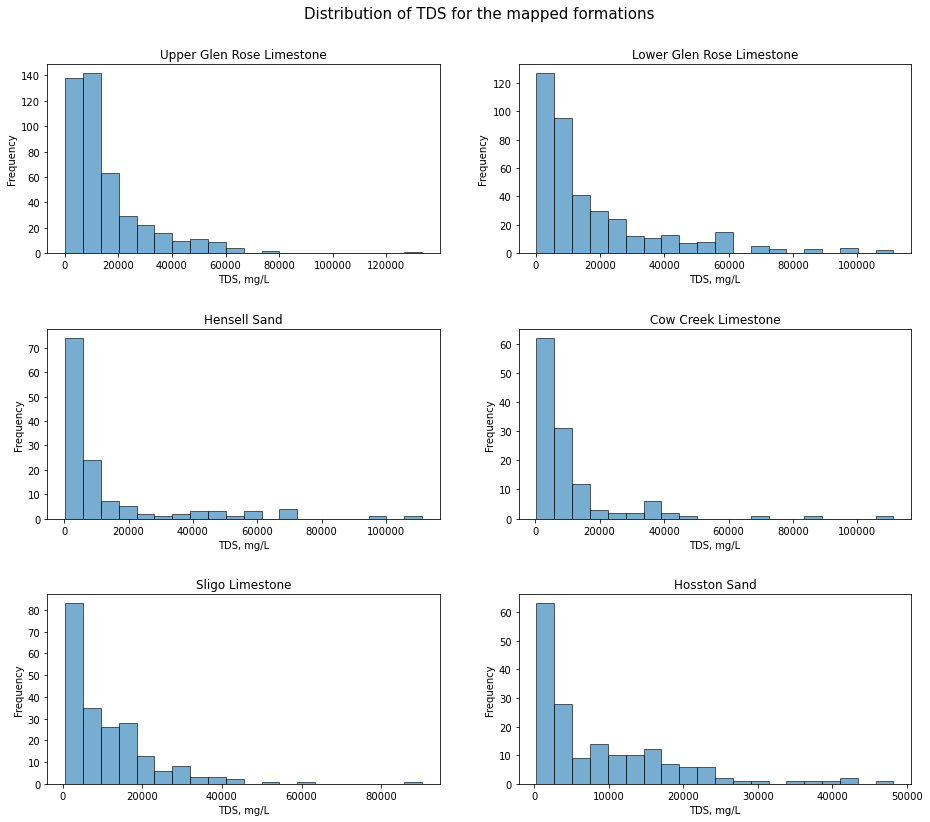

In [16]:
#assign dataframes and formation names to lists for convenience
df_fm_list=[UGR,LGR,HE,CC,SL,HO]
formations=['Upper Glen Rose Limestone','Lower Glen Rose Limestone','Hensell Sand','Cow Creek Limestone','Sligo Limestone',
            'Hosston Sand']

i=1    #subplot index
fm=0   #list index
#plot TDS distributions
fig=plt.figure()
for n in range (1,7):
    fig.add_subplot(3,2,i)
    plt.hist(df_fm_list[fm]['TDS'],bins=20,alpha=0.6,edgecolor='black')
    plt.title(formations[fm])
    plt.xlabel('TDS, mg/L')
    plt.ylabel('Frequency')

    fm=fm+1
    i=i+1

fig.subplots_adjust(left=0,bottom=0,right=2,top=2.5,wspace=0.2,hspace=0.4)
fig.suptitle(('Distribution of TDS for the mapped formations'),x=1,y=2.7,fontsize=15);

## Bootstrap the TDS values
We'll first bootstrap the TDS values we calculated. For transparency, this is not the best way to bootstrap a calculated parameter. We'll bootstrap the TDS calculation, from input to estimated TDS, later.

First, we'll bootstrap the full original dataset and the reduced dataset (TDS <= 35,000 mg/L TDS).

Notice how the bootstrap realizations have a similar shape to the TDS histogram we plotted earlier. One big difference is due to plotting parameters we selected (kde=True), there are 'negative' TDS values.

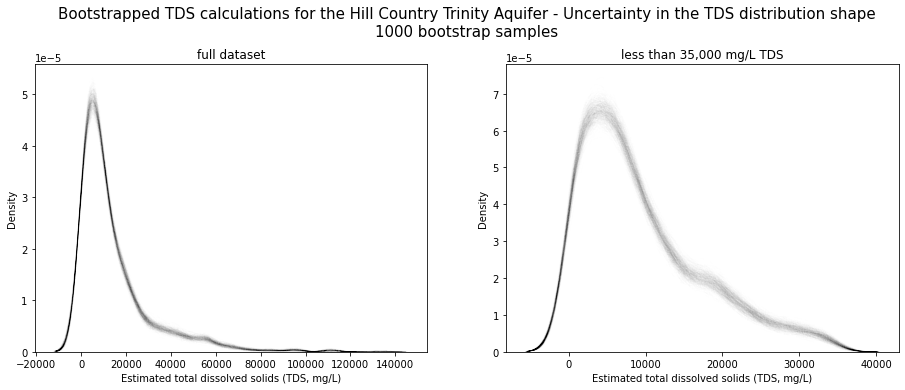

In [17]:
L=1000   #number of bootstrap sample events
i=1      #subplot index

#assign dataframes and short descriptors to lists for convenience
dfs_list=[df_total,df_select]
dfs_titles=['full dataset','less than 35,000 mg/L TDS']
dfs=0    #index of lists

#we will save summary statistics returned by the function in the following arrays
mean=np.zeros(len(dfs_list))
stdev=np.zeros(len(dfs_list))
P10=np.zeros(len(dfs_list))
P50=np.zeros(len(dfs_list))
P90=np.zeros(len(dfs_list))

#bootstrap the TDS values from the original dataset
l=0
fig=plt.figure()
for n in range (0,2):
    fig.add_subplot(1,2,i)
    plot,mean_v,stdev_v,P10_v,P50_v,P90_v=RandomPoint_Bootstrap(L,dfs_list[dfs],dfs_titles[dfs])
    
    mean[l]=mean_v
    stdev[l]=stdev_v
    P10[l]=P10_v
    P50[l]=P50_v
    P90[l]=P90_v
    
    dfs=dfs+1
    i=i+1
    l=l+1

fig.subplots_adjust(left=0,bottom=0,right=2,top=1,wspace=0.2,hspace=0.4)
fig.suptitle(('Bootstrapped TDS calculations for the Hill Country Trinity Aquifer - Uncertainty in the TDS distribution '
              +'shape\n'+str(L)+' bootstrap samples'),x=1,y=1.2,fontsize=15);

#turn summary arrays into a dataframe
data={'Dataset':dfs_titles,'mean':mean,'stdev':stdev,'P10':P10,'P50':P50,'P90':P90}
df_summary_Point=pd.DataFrame(data,columns=['Dataset','mean','stdev','P10','P50','P90'])

If we look at the summary statistics, we see that excluding samples with a TDS greater than 35,000 mg/L cut the standard deviation in half. Additionally, it narrowed the P10 to P90 range.

In [18]:
df_summary_Point['P90-P10']=df_summary_Point['P90']-df_summary_Point['P10']
df_summary_Point.head(n=len(dfs_list))

,Dataset,mean,stdev,P10,P50,P90,P90-P10
0,full dataset,14199.0,16547.0,1360.0,6977.0,13068.0,11708.0
1,"less than 35,000 mg/L TDS",9537.0,7914.0,923.0,4707.0,8717.0,7794.0


Next, we'll bootstrap the TDS values for each of the mapped formations:

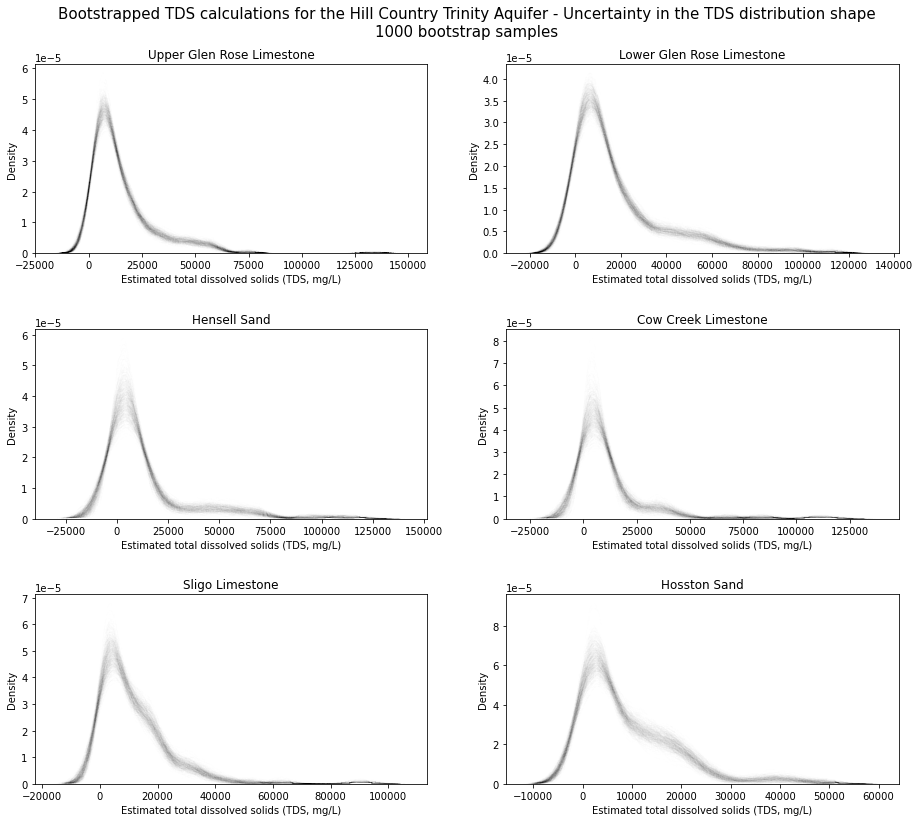

In [19]:
L=1000
i=1
fm=0     #index from the formation lists

#we will save summary statistics returned by the function in the following arrays
mean=np.zeros(len(formations))
stdev=np.zeros(len(formations))
P10=np.zeros(len(formations))
P50=np.zeros(len(formations))
P90=np.zeros(len(formations))

#bootstrap the TDS values from the dataset
l=0
fig=plt.figure()
for n in range (1,7):
    fig.add_subplot(3,2,i)
    plot,mean_v,stdev_v,P10_v,P50_v,P90_v=RandomPoint_Bootstrap(L,df_fm_list[fm],formations[fm])
    
    mean[l]=mean_v
    stdev[l]=stdev_v
    P10[l]=P10_v
    P50[l]=P50_v
    P90[l]=P90_v
    
    fm=fm+1
    i=i+1
    l=l+1
    
fig.subplots_adjust(left=0,bottom=0,right=2,top=2.5,wspace=0.2,hspace=0.4)
fig.suptitle(('Bootstrapped TDS calculations for the Hill Country Trinity Aquifer - Uncertainty in the TDS distribution '
              +'shape\n'+str(L)+' bootstrap samples'),x=1,y=2.7,fontsize=15);

#make a dataframe from the summary statistics returned from the function for easy plotting
data={'Dataset':formations,'mean':mean,'stdev':stdev,'P10':P10,'P50':P50,'P90':P90}
df_summary_PointFms=pd.DataFrame(data,columns=['Dataset','mean','stdev','P10','P50','P90'])

The Hosston Sand appears to have the tightest distribution of TDS. If we look at the summary statistics, we see that it also has the lowest standard deviation and narrowest P10 to P90, and the Lower Glen Rose has the highest standard deviation and range of P10 to P90.

In [20]:
df_summary_PointFms['P90-P10']=df_summary_PointFms['P90']-df_summary_PointFms['P10']
df_summary_PointFms.head(n=len(formations))

,Dataset,mean,stdev,P10,P50,P90,P90-P10
0,Upper Glen Rose Limestone,15529.0,14904.0,1449.0,7569.0,14406.0,12957.0
1,Lower Glen Rose Limestone,18057.0,20304.0,1652.0,8727.0,16830.0,15178.0
2,Hensell Sand,12708.0,19720.0,1005.0,5836.0,12557.0,11552.0
3,Cow Creek Limestone,10804.0,15418.0,859.0,4982.0,10567.0,9708.0
4,Sligo Limestone,11502.0,11635.0,1027.0,5506.0,10841.0,9814.0
5,Hosston Sand,8861.0,9195.0,775.0,4233.0,8461.0,7686.0


## Bootstrap the TDS calculations
We'll now bootstrap the entire TDS calculation for each of our dataframes, which is the more correct way to estimate uncertainty in a calculated value. 

When we bootstrap the calculation, we will randomly select input parameters with replacement.

First, we'll bootstrap the calculation from the full, original dataset and the reduced dataset (TDS <= 35,000 mg/L).

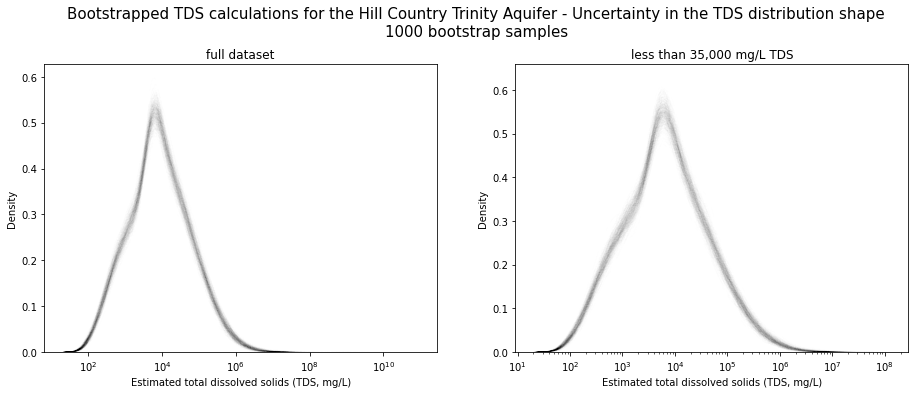

In [21]:
L=1000
i=1
dfs=0

#we will save summary statistics returned by the function in the following arrays
mean=np.zeros(len(dfs_list))
stdev=np.zeros(len(dfs_list))
P10=np.zeros(len(dfs_list))
P50=np.zeros(len(dfs_list))
P90=np.zeros(len(dfs_list))

#bootstrap the TDS calculations
l=0
fig=plt.figure()
for n in range (0,2):
    fig.add_subplot(1,2,i)
    plot,mean_v,stdev_v,P10_v,P50_v,P90_v=RandomValue_Bootstrap(L,dfs_list[dfs],dfs_titles[dfs])
    
    #assign values to the summary arrays
    mean[l]=mean_v
    stdev[l]=stdev_v
    P10[l]=P10_v
    P50[l]=P50_v
    P90[l]=P90_v
    
    #increase counters
    dfs=dfs+1
    i=i+1
    l=l+1
    
fig.subplots_adjust(left=0,bottom=0,right=2,top=1,wspace=0.2,hspace=0.4)
fig.suptitle(('Bootstrapped TDS calculations for the Hill Country Trinity Aquifer - Uncertainty in the TDS distribution '
              +'shape\n'+str(L)+' bootstrap samples'),x=1,y=1.2,fontsize=15);

#make a dataframe from the summary statistics returned from the function
data={'Dataset':dfs_titles,'mean':mean,'stdev':stdev,'P10':P10,'P50':P50,'P90':P90}
df_summary_Value=pd.DataFrame(data,columns=['Dataset','mean','stdev','P10','P50','P90'])

When we exclude the very saline samples from the bootstrap sampling, we reduce the maximum estimate TDS by several orders of magnitude. This is reflected by both the mean, standard deviation, and range in P10 to P90 below. The general shape of both distributions is very similar, despite the differences in TDS range.

In [22]:
df_summary_Value['P90-P10']=df_summary_Value['P90']-df_summary_Value['P10']
df_summary_Value.head(n=len(dfs_list))

,Dataset,mean,stdev,P10,P50,P90,P90-P10
0,full dataset,109893.0,2207793.0,677.0,7759.0,108792.0,108115.0
1,"less than 35,000 mg/L TDS",40385.0,178328.0,594.0,6351.0,76558.0,75964.0


Next we'll bootstrap the TDS calculations for each mapped formation.

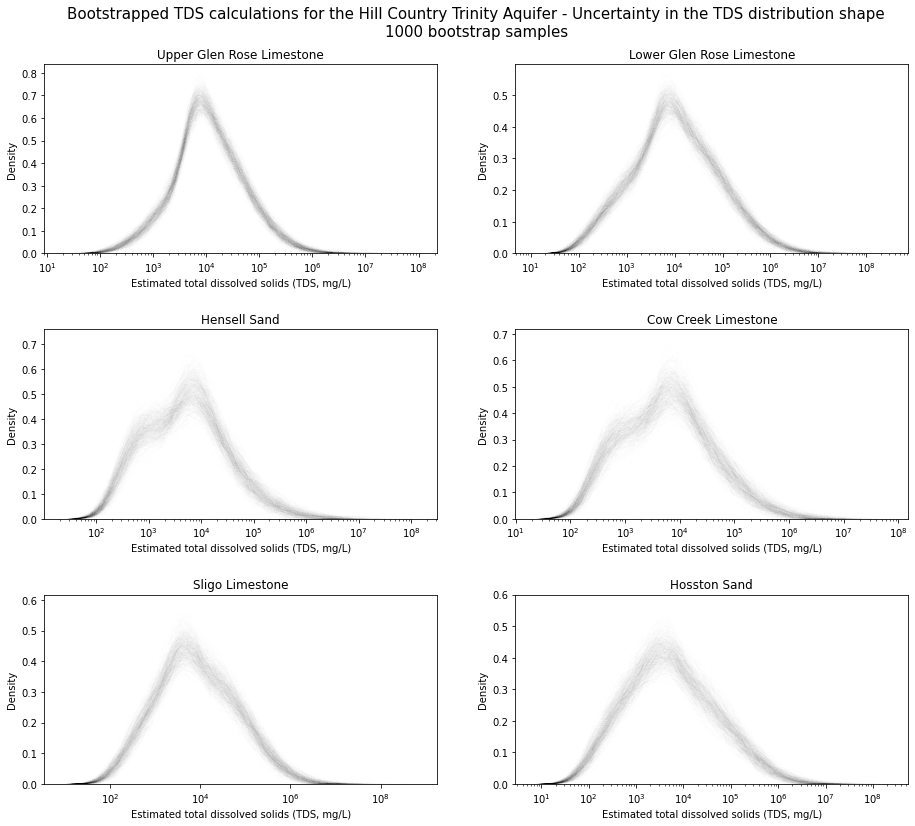

In [23]:
L=1000
i=1
fm=0

#we will save summary statistics returned by the function in the following arrays
mean=np.zeros(len(formations))
stdev=np.zeros(len(formations))
P10=np.zeros(len(formations))
P50=np.zeros(len(formations))
P90=np.zeros(len(formations))

#bootstrap the TDS calculations
l=0
fig=plt.figure()
for n in range (1,7):
    fig.add_subplot(3,2,i)
    plot,mean_v,stdev_v,P10_v,P50_v,P90_v=RandomValue_Bootstrap(L,df_fm_list[fm],formations[fm])
    
    mean[l]=mean_v
    stdev[l]=stdev_v
    P10[l]=P10_v
    P50[l]=P50_v
    P90[l]=P90_v
    
    l=l+1
    i=i+1
    fm=fm+1
    
fig.subplots_adjust(left=0,bottom=0,right=2,top=2.5,wspace=0.2,hspace=0.4)
fig.suptitle(('Bootstrapped TDS calculations for the Hill Country Trinity Aquifer - Uncertainty in the TDS distribution '
              +'shape\n'+str(L)+' bootstrap samples'),x=1,y=2.7,fontsize=15);

data={'Dataset':formations,'mean':mean,'stdev':stdev,'P10':P10,'P50':P50,'P90':P90}
df_summary_ValueFms=pd.DataFrame(data,columns=['Dataset','mean','stdev','P10','P50','P90'])

When we bootstrap the TDS calculations, the Hosston Sand no longer appears to have the least amount of uncertainty in TDS. Instead, the Hensell Sand has the lowest standard deviation and P10 to P90 range. However, the Lower Glen Rose Limestone still appears to have the most uncertainty in TDS given the range of P10 to P90 values and standard deviation.

In [24]:
df_summary_ValueFms['P90-P10']=df_summary_ValueFms['P90']-df_summary_ValueFms['P10']
df_summary_ValueFms.head(n=len(formations))

,Dataset,mean,stdev,P10,P50,P90,P90-P10
0,Upper Glen Rose Limestone,39410.0,136973.0,1722.0,10115.0,78903.0,77181.0
1,Lower Glen Rose Limestone,82802.0,370511.0,742.0,9394.0,148594.0,147852.0
2,Hensell Sand,28811.0,111784.0,522.0,5407.0,48148.0,47626.0
3,Cow Creek Limestone,33167.0,111707.0,539.0,5973.0,63232.0,62693.0
4,Sligo Limestone,61198.0,239846.0,653.0,6717.0,118731.0,118078.0
5,Hosston Sand,51120.0,202984.0,387.0,4557.0,96844.0,96457.0


You may have noticed that when we bootstrapped the TDS calculation, the mean TDS increased by several orders of magnitude. Let's look at 5 examples of the data selected by bootstrapping and compare TDS v RXO/RO from the original dataset to the bootstrapped samples.

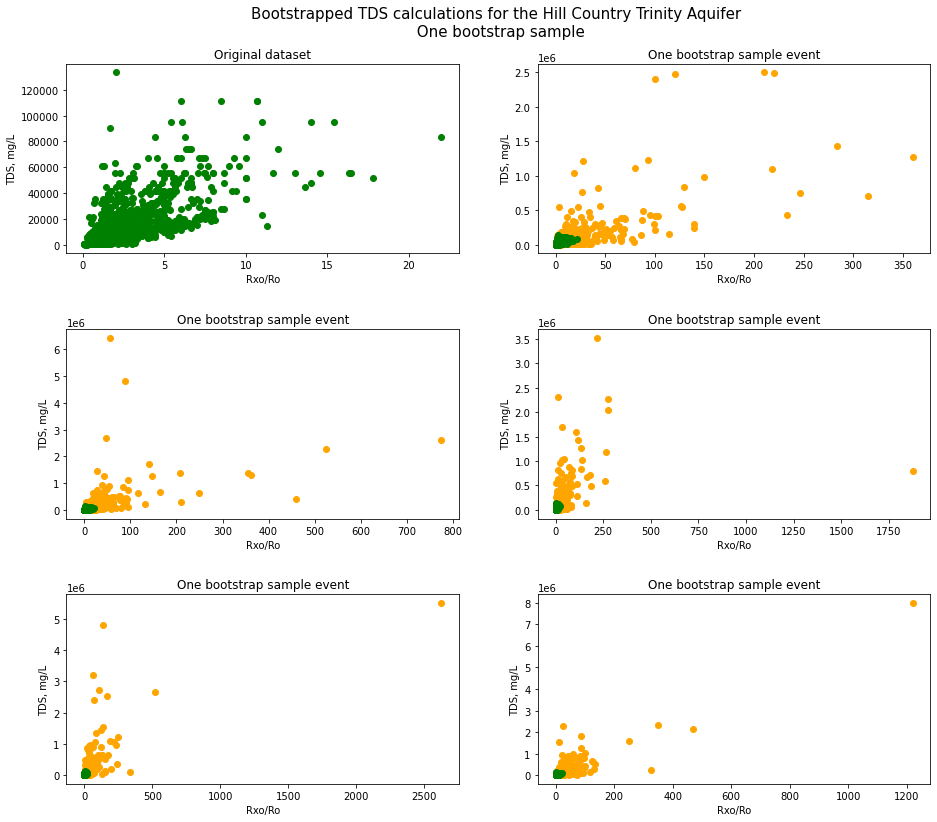

In [25]:
fig=plt.figure()
fig.add_subplot(321)
plt.scatter(x=(df_total['RXO']/df_total['RO']),y=df_total['TDS'],color='green')
plt.xlabel('Rxo/Ro')
plt.ylabel('TDS, mg/L')
plt.title('Original dataset')

i=2
for n in range(2,7):
    fig.add_subplot(3,2,i)
    RandomValueOnce_Bootstrap(df_total,'RXO/RO')
    plt.scatter(x=(df_total['RXO']/df_total['RO']),y=df_total['TDS'],color='green')
    i=i+1

fig.subplots_adjust(left=0,bottom=0,right=2,top=2.5,wspace=0.2,hspace=0.4)

fig.suptitle(('Bootstrapped TDS calculations for the Hill Country Trinity Aquifer \n One bootstrap sample'),
             x=1,y=2.7,fontsize=15);

The way we sampled from the original dataset was insensitive to potential relationships between the parameters. For example, a Df of >10000 is unlikely to have an LR_TBH of 71 and would likely result in an invalid TDS value. Alternatively, a Df of 101 is unlikely to have an LR_TBH of 300. In the above plots, it is interesting that although the magnitudes are very different, TDS v RXO/RO have similar shapes (heteroscedastic, increasing). Let's look at some bootstrap distributions of LR_TBH v Df:

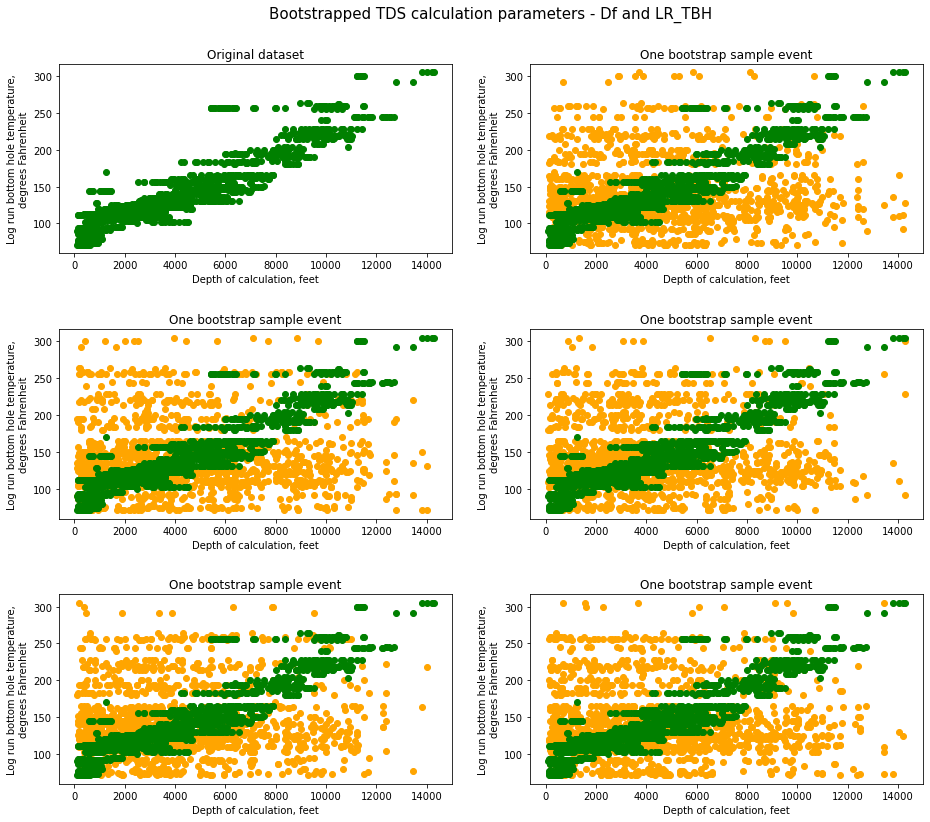

In [26]:
fig=plt.figure()
fig.add_subplot(321)
plt.scatter(x=df_total['DF'],y=df_total['LR_TBH'],color='green')
plt.xlabel('Depth of calculation, feet')
plt.ylabel('Log run bottom hole temperature,\ndegrees Fahrenheit')
plt.title('Original dataset')

i=2
for n in range(2,7):
    fig.add_subplot(3,2,i)
    RandomValueOnce_Bootstrap(df_total,'LR_TBH')
    plt.scatter(x=(df_total['DF']),y=df_total['LR_TBH'],color='green')
    i=i+1

fig.subplots_adjust(left=0,bottom=0,right=2,top=2.5,wspace=0.2,hspace=0.4)

fig.suptitle(('Bootstrapped TDS calculation parameters - Df and LR_TBH'),x=1,y=2.7,fontsize=15);

Immediately we can see that treating all combinations of Df and LR_TBH as equal is both unreal and problematic for our calculations. This relationship, and other relationships between input parameters, likely inflated the TDS estimates in the bootstrapped calculations.

## Results
From the bootstrap visualizations and summary statistics, it is quite clear that there is a large amount of uncertainty in the TDS estimates. Considering there are many necessary input parameters, there are many avenues for uncertainty to compound and enter enter the final estimate of TDS. Additionally, some input parameters, like Df and LR_TBH, have dependencies and not all samples are equally likely. A Markov chain Monte Carlo simulation would be a better way to estimate uncertainty in TDS than plain bootstrapping.

Additionally, perhaps a different calculation method that utilizes fewer input parameters, like the [Rwa minimum method (GSA presentation PDF download)](https://www.twdb.texas.gov/innovativewater/bracs/doc/PowerPoints/4-1_Croskrey_Utilizing_Resistivity_Logs_QC_Fm_TDS_20190325.pdf?d=8381.414999981644), would provide more certain estimates of TDS.

Aside from general observations of uncertainty, we learned that some formations have more uncertainty than others. For example, summary statistics suggest that the TDS estimates of the Lower Glen Rose Limestone are less certain than the Hensell Sand.

#### How can we use this information?
Considering there is significant uncertainty in the TDS estimates, I would recommend that the mapping be used to focus on areas for further investigation instead of focusing on areas to place brackish groundwater production wells. Additionally, bootstrapping illuminates that although we did more analysis of the Lower Glen Rose Limestone (n=400) than the Hensell Sand (n=131), the TDS estimates are less certain in the the Lower Glen Rose Limestone.

#### Want more details on mapping brackish groundwater in Texas?
If you're curious about the results of this study or mapping brackish groundwater in Texas, shoot me an email (alysa.suydam@twdb.texas.gov) or visit the [BRACS webpage](https://www.twdb.texas.gov/innovativewater/bracs/index.asp). We have various reports, presentations, GIS datasets, and the BRACS database available to download.

*Alysa*

Alysa Suydam, TX PG 15118, Graduate student at the Jackson School of Geosciences, Hydrologist at the Texas Water Development Board

## References
Alger, R.P., and Harrison, C.W., 1989, Improved fresh water assessment in sand aquifers utilizing geophysical well logs: The Log Analyst, v. 30, no. 1, p. 31-44.

Blackwell, D., Richards, M., and Stepp, P., 2010, Texas geothermal assessment for the I35 Corridor East for Texas State Energy Conservation Office contract CM709: SMU Geothermal Laboratory Contract Report, 78 p. with appendices.

Larkin, T.J., and Bomar, G.W., 1983, Climatic atlas of Texas: Texas Department of Water Resources LP-192, 151 p.

Pyrcz, M., 2020, SubsurfaceDataAnalytics_bootstrap.ipynb. Retrieved from https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_bootstrap.ipynb.